# Neural Network from Scratch
In this notebook, I implement a configurable fully connected neural network from scratch, then use it to create text embeddings.

I built this project to practice translating mathematical concepts (e.g., forward and backward prop, gradient descent) into vectorized code. As such, I relied only on math walkthroughs and did not reference anyone else's code. Two of my favorite resources were:
- [3Blue1Brown: Backpropagation Calculus](https://www.3blue1brown.com/lessons/backpropagation-calculus)
- [Backprop scroll-through visualization](https://developers-dot-devsite-v2-prod.appspot.com/machine-learning/crash-course/backprop-scroll/)

Author: [Ryan Parker](https://github.com/rparkr)

## Required packages

In [1]:
# built-in packages
from typing import Union  # type annotations for functions

# third-party packages
import numpy as np  # array-based computation

# Functions
In this section, I implement functions and their derivatives for use in the forward and backward passes of the neural network.

In [378]:
def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    '''Calculate probabilities using the sigmoid function on input data, z.
    The sigmoid, or logistic, function is used as an activation for
    neurons of a neural network because it is non-linear.

    Parameters
    ----------
    z: {float, np.ndarray}
        The input to be passed through the sigmoid function.
        Typically, input values come from a linear combination
        of input values with weights and a bias term. That is,
        some form of y = wx + b.

    Returns
    -------
    sigmoid_value: {float, np.ndarray}
        The output of the sigmoid function, in the same
        shape as the input.
    '''
    return 1 / (1 + np.exp(-z))


def df_sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    '''Compute the derivative of the sigmoid function,
    which is sigmoid(z) * (1-sigmoid(z)).
    
    Parameters
    ----------
    z: {float, np.ndarray}
        The input to be passed through the sigmoid function.
        Typically, input values come from a linear combination
        of input values with weights and a bias term. That is,
        some form of y = wx + b.
    '''
    # See: https://beckernick.github.io/sigmoid-derivative-neural-network/
    out = sigmoid(z)
    return out * (1 - out)


def relu(x_input: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    '''Compute the Rectified Linear Unit activation function.'''
    return np.maximum(x_input, 0)


def df_relu(x_input: np.ndarray) -> np.ndarray:
    '''Compute the derivative of the ReLU activation function,
    which is 0 when x < 0 and 1 when x > 0.'''
    # First, set everything to zeros
    out = np.zeros_like(x_input)
    # Then set to 1 where x_input > 0
    out[x_input > 0] = 1
    return out


def linear(
        x_input: np.ndarray,
        weights: np.ndarray,
        bias: np.ndarray) -> np.ndarray:
    '''Compute a linear function: y = wx + b.
    
    Returns
    -------
    y_hat: the computed value(s) after multiplying
        inputs by the weights and adding a bias.
    '''
    # Matrix-multiplication with the @ operator
    y_hat = (x_input @ weights) + bias
    return y_hat


def mse_loss(y_hat: np.ndarray, y_target: np.ndarray) -> float:
    '''Compute the mean squared error loss function.
    
    Parameters:
    ----------
    y_hat: array of shape (m_samples,)
        Predictions output from the model.
    y_target: array of shape (m_samples,)
        The true labels, or targets to predict.

    Returns:
    -------
    loss: float
        A measure of the average distance between predicted and target values.
    '''
    num_samples = y_hat.shape[0]
    # Below, dividing by 2m is the same as multiplying by (1/2m)
    return np.sum((y_hat - y_target) ** 2) / (2 * num_samples)


def df_mse_loss(
    y_hat: np.ndarray, y_target: np.ndarray) -> np.ndarray:
    '''Compute the derivative of mean-squared error loss with respect
    to the final outputs of the network. Returns the gradients of the
    activations from the final layer of the network.

    Used for regression problems, where the target is a continuous
    variable.
    
    Parameters
    ----------
    y_hat: array of shape (m_samples,)
        The network's outputs (predictions).
    y_target: array of shape (m_samples,)
        The labels being predicted, or "ground truth."
    
    Returns
    -------
    derivatives: array of shape (m_samples,)
        The derivative of the mean-squared error loss with respect
        to the output from the network.
    '''
    return y_hat - y_target


def softmax(x_input: np.ndarray, axis: int=1) -> np.ndarray:
    '''Compute the softmax function on an input array.
    
    Softmax creates a probability distribution across
    the input, where rank ordering is preserved but
    absolute values change such that the sum of all
    probability values output from softmax equals 1.

    Equation: e^x / sum(e^x) for all classes
    '''
    # e^x for all x
    e_x = np.exp(x_input)
    # Align the sum as a column using [:, np.newaxis]
    return e_x / np.sum(e_x, axis=axis)[:, np.newaxis]


def df_softmax(x_input: np.ndarray) -> np.ndarray:
    '''Compute the derivative of the softmax function 
    with respecct to an input array.
    
    Equation:
    For input index i = output index j:
        df_softmax = softmax(x_i) * (1 - softmax(x_i))
    For input position i != output position j:
        df_softmax = -softmax(x_i) * softmax(x_j)
    '''
    # First, the case where i != j
    # ...
    # We don't actually need to compute this,
    # because the derivative of cross entropy loss
    # with respect to the softmax outputs already 
    # takes this into account.
    pass


def cross_entropy_loss(y_hat: np.ndarray, y_target: np.ndarray) -> float:
    '''Compute the cross-entropy loss over the network's outputs.

    Equation: -sum(y_target * log(y_hat)) for all samples in the batch.
    
    Parameters
    ----------
    y_hat: array of shape (m_samples, n_classes)
        The network's outputs (predictions), after being
        passed through softmax to return a probability
        distribution across the classes.
    y_target: array of shape (m_samples, n_classes)
        A one-hot coded array where each row is a sample
        and each column is a possible class, with a 1
        in the position of the correct class for that
        sample.
    
    Returns
    -------
    loss: float
        The cross-entropy loss for the given batch.
    
    '''
    # Transpose y_hat (.T) to swap the axes to (n_classes, m_samples)
    # for the matrix multiplication to work properly.
    num_samples = y_hat.shape[0]
    return -np.sum(y_target @ np.log(y_hat.T)) / (num_samples ** 2)


def df_cross_entropy_loss(
        y_hat: np.ndarray, y_target: np.ndarray) -> np.ndarray:
    '''Compute the derivative of the cross-entropy loss funtion
    with respect to the output of the softmax function.
    
    Parameters
    ----------
    y_hat: array of shape (m_samples, n_classes)
        The network's outputs (predictions), after being
        passed through softmax to return a probability
        distribution across the classes.
    y_target: array of shape (m_samples, n_classes)
        A one-hot coded array where each row is a sample
        and each column is a possible class, with a 1
        in the position of the correct class for that
        sample.
    
    Returns
    -------
    derivatives: array of shape (m_samples, n_classes)
        The derivative of cross-entropy loss with respect
        to the output from the softmax function.
    '''
    return y_hat - y_target



# Neural network
The model is a fully connected network, with configurable parameters for the number of layers and the number of neurons per layer. To enable that flexibility, I've chosen to implement the model as a class that can be instantiated into a neural network object that can be trained and used for inference.

In [413]:
class nn():
    '''Create a fully connected neural network with a configurable number of layers and neurons.'''
    def __init__(
            self,
            input_dim: int,
            n_layers: int, 
            neurons_per_layer: Union[int, list[int]], 
            bias: Union[bool, list[bool]] = True,
            activation: str='relu',
            lambda_: float = 0.0,
            loss_fn: str = 'cross_entropy',
            alpha: float = 0.001,
            dtype: np.dtype = np.float32,
            seed: Union[int, None] = None):
        '''Instantiate a neural network as a model object that performs
        computations on input data and returns the outputs
        of those computations. Parameters (weights and biases) are
        intitialized to normally-distributed random values with mean 0 
        and standard deviation of 1.

        Parameters
        ----------
        input_dim: int
            The dimension of the inputs to the model (i.e, the number
            of features per input sample).
        n_layers: int
            The number of layers in the network including all hidden layers
            and the output layer.
        neurons_per_layer: {int, list[int]}
            The number of neurons in each layer of the network. If an `int`,
            then all layers will have the same number of neurons. If a
            `list`, then its `len()` must equal `n_layers`, where each
            element in the list holds the number of neurons in the 
            corresponding layer of the network.
        bias: {bool, list[bool]}, default = True
            Whether to include a bias term for the neurons in the network.
            If `True`, all neurons in the network will have a bias term.
            If a list of `bool` values is provided, each layer of the network
            will (or won't) have a bias term for its neurons based on the
            corresponding element in the list. If a list, the number of
            elements must equal `n_layers`.
        activation: {'relu', 'sigmoid'}, default='relu'
            The activation function to use after passing input through each
            linear layer.
        lambda_: float in the range [0.0, inf), default=0.0
            The weighting factor for the regularizing
            term in the loss calculation. If set to 0.0,
            no regularization will be used. The larger
            this value, the more weights are penalized
            and the smaller the weights will be after
            training through gradient descent.
        loss_fn: {'cross_entropy', 'ce', 'mean_squared_error', 'mse'}
            The loss function used for the network. Valid values are
            'cross_entropy' or 'mean_squared_error' or an abbreviation.
            Use 'mean_squared_error' for regression tasks and set the
            output layer to a single neuron.
            Use 'cross_entropy' for classification tasks and set
            the number of output neurons to the number of possible classes.
            Softmax is automatically applied after the output layer when
            using 'cross_entropy' loss.
        alpha: float, default=0.001
            The learning rate, which scales the step size taken during
            each pass through gradient descent. Gradients are calculated
            in the nn.backward() method and descent happens in nn.step().
        dtype: np.dtype, default=np.float32
            The data type to use for network parameters. Inputs to the network
            should also be in this same data type. NumPy's default is float64,
            but most neural networks use float32 or float16 precision to save
            memory and computation resources.
        seed: int, default=None
            For reproducibility, set a seed that will be used
            when initializing parameter values. 

        Returns
        -------
        self: an instance of `nn` with randomly-initialized weights.

        Methods
        -------
        forward(input): compute a forward pass through the network,
            returning the output from the final layer.
        backward(input, target): compute a backward pass through the network,
            storing the partial derivatives of the parameters
            with respect to the loss.
        zero_grad(): clears (zeros-out) the stored gradients.
        step(): update the parameters by taking a step (scaled by alpha)
            in the negative direction of the gradient.

        Attributes
        ----------
        params: a dict of the network's parameters by layer
        n_params: the total number of parameters in the network,
            including weights and biases.
        grad: a dict of the gradients for each of the parameters
            in the network, computed after calling backward().
        outputs: a dict of the intermediate outputs after each layer,
            including inputs to activation functions and the activations
            after passing through activation functions.
            Used for backpropagation.
        input_dim: the size of the input that will be passed into the
            network. The network will expect all inputs to have this
            same dimension. Since each input sample is a vector, this
            is the number of features in an input row.
        n_layers: The number of layers in the network, including hidden
            layers and the output layer (excluding the input).
        neurons_per_layer: An integer or a list of integers representing
            the number of neurons in each layer.
        bias: A boolean value or a list of boolean values representing
            whether each layer has a bias term added to it.
        '''
        
        # Validate arguments
        if type(input_dim) != int:
            raise TypeError(f"input_dim must be an integer, but the provided value was: {type(input_dim)}")

        if type(n_layers) != int:
            raise TypeError(f"n_layers must be an integer, but the provided value was: {type(n_layers)}")
        
        if type(neurons_per_layer) not in (int, list):
            raise TypeError(f"neurons_per_layer must be an int or a list of int, not: {type(neurons_per_layer)}")
        elif type(neurons_per_layer) == list:
            if len(neurons_per_layer) != n_layers:
                raise ValueError(f"If neurons_per_layer is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != int for i in neurons_per_layer]):
                raise TypeError("neurons_per_layer must be an int or a list of int. Not all elements provided in neurons_per_layer were of the int type.")
        
        if type(bias) not in (bool, list):
            raise TypeError(f"bias must be a bool or a list of bool, not {type(bias)}")
        elif type(bias) == list:
            if len(bias) != n_layers:
                raise ValueError(f"If bias is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != bool for i in bias]):
                raise TypeError("bias must be a bool or a list of bool. Not all elements provided in bias were of the bool type.")
        
        if activation not in ('relu', 'sigmoid'):
            raise ValueError(f"activation must be a str, either 'relu' or 'sigmoid', not {activation}")

        if type(lambda_) != float:
            raise TypeError(f"The regularizing strength parameter, lambda_, must be of type `float`, not {type(lambda_)}")
        
        if type(loss_fn) != str:
            raise TypeError(f"loss_fn must be a str value, not {type(loss_fn)}")
        elif loss_fn[0] not in ['c', 'm']:
            raise ValueError(f"loss_fn must be 'cross_entropy', 'mean_squared_error', or an abbreviation, not {loss_fn}")

        if type(alpha) != float:
            raise TypeError(f"The learning rate parameter, alpha, must be of type `float`, not {type(alpha)}")

        # Update object's parameters (equivalent to self.n_layers = n_layers; self.bias = bias; ...)
        self.__dict__.update(locals())

        # If neurons_per_layer and bias are individual values, convert them 
        # to lists to use when creating layers
        if type(neurons_per_layer) == int:
            neurons_per_layer = [neurons_per_layer for _ in range(n_layers)]
        if type(bias) == bool:
            bias = [bias for _ in range(n_layers)]
    
        # Create layers (parameters).
        # If you want to calculate gradients through the inputs, start these
        # dicts at 0 and update the iteration loop in the backward() function
        # to go all the way to the 0th layer (rather than layer 1).
        self.params = {}
        self.grad = {}
        input_sizes = [input_dim]
        input_sizes.extend(neurons_per_layer[:-1])
        for n in range(n_layers):
            p = self._linear_layer(
                input_sizes[n], neurons_per_layer[n], bias[n], seed=seed)
            self.params[n+1] = p
            # Initialize gradients to 0s
            self.grad[n+1] = np.zeros_like(p)
                
        # The second expression counts bias terms only for layers with a bias
        self.n_params = (np.dot(input_sizes, neurons_per_layer) 
                         + np.dot(bias, neurons_per_layer))

        # A running count of the number of parameter updates made
        # i.e., the number of steps taken during training
        self.n_steps = 0


    def _linear_layer(
            self,
            input_size: int,
            n_neurons: int,
            bias: bool,
            seed: Union[int, None]):
        '''Create a linear layer. Used when constructing the network
        at time of instantiation.
        
        The input size determines the number of weights (rows) and the
        number of neurons determines the number of columns.
        
        The bias is a 1D NumPy array with len() equal to the n_neurons and is
        appended as a final row in the weight matrix.
        
        During the forward pass, a column of `1`s is added to the input so,
        when multiplied by the weight matrix, those `1`s line up with the final
        row in the weight matrix, which are the bias terms. That has the same
        effect as multiplying the input by the weight matrix and then adding
        the bias vector, which would be broadcast down the rows.
        
        This structure simplifies backpropagation: only the weight matrices
        need to be calculated and updated, since the weight matrices include
        the bias terms in the last row.
        '''
        # set up random number generator
        rng = np.random.default_rng(seed)
        # Generate the weight and bias arrays
        w = rng.normal(size=(input_size, n_neurons))
        if bias:
            b = rng.normal(size=(n_neurons))
        else:
            b = np.zeros(shape=(n_neurons))
        # Add the bias as the last row in the weight matrix, prepending
        # a dimension to b for the concatenation.
        # Also convert to the float32 data type, which saves memory
        # over NumPy's default float64. In practice, float32 and float16
        # are the most common data types for neural network parameters.
        return np.concatenate((w, b[np.newaxis, :]), axis=0).astype(self.dtype)


    def forward(self, input: np.ndarray):
        '''Pass inputs through the network and return the outputs from
        the final network layer.

        During the forward pass, a column of `1`s is added to the input,
        as if there were an extra neuron in the input with an activation
        of 1, such that when multiplied by the weight matrix whose final
        row has bias terms, the effect is the same as multiplying the
        input matrix by the weight matrix and then adding a row vector of
        bias terms, which would be broadcast down the columns.
        
        Parameters
        ----------
        input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        '''
        # Validate input
        input_size = input.shape[1] if input.ndim > 1 else input.shape[0]
        if input_size != self.input_dim:
            raise ValueError(f"Passed input of size {input_size} does not match"
                             f" expected size of input_dim: {self.input_dim}.")
        
        if self.activation not in ('relu', 'sigmoid'):
            print(
                f"WARNING: Activation function, '{self.activation}', is not one of the acceptable values: "
                "('relu', 'sigmoid'), so the default ('relu') is being used. Use "
                "nn.activation = 'relu' or nn.activation = 'sigmoid' "
                "to change this setting.")
        # Store intermediate outputs to use with backprop, starting with
        # the input layer. 'z' is what goes into the activation function
        # for a given layer: the layer's inputs multiplied by its weights
        outputs = {
            0: {'z': input, 'activation': input}
        }

        # Compute at each layer and pass to the next
        y_hat = input
        # Ensure the input has 2 dimensions to simplify adding the bias column.
        if y_hat.ndim == 1:
            y_hat = y_hat[np.newaxis, :]
        for n in range(1, self.n_layers + 1):
            # Add a column with weights of 1 to be multiplied with the
            # bias terms (the final row in the weights matrix)
            ones_col = np.ones((y_hat.shape[0], 1), dtype=y_hat.dtype)
            y_hat = np.concatenate((y_hat, ones_col), axis=1)
            outputs[n-1]['activation'] = y_hat
            # input array * weights matrix (matrix multiplication)
            y_hat = y_hat @ self.params[n]
            outputs[n] = {'z': y_hat}
            if self.activation == 'sigmoid':
                y_hat = sigmoid(y_hat)
            else:
                y_hat = relu(y_hat)
        # Save the final layer's activation (which doesn't have a column of
        # ones added to it)
        outputs[n]['activation'] = y_hat
        # Finish with softmax if using cross-entropy loss.
        if self.loss_fn[0] == 'c':
            y_hat = softmax(x_input=y_hat, axis=1)
        # Softmax outputs don't need to be stored because I "skip over"
        # the softmax derivative by combining it with the derivative
        # for cross-entropy loss.
        # Store output and activation values
        self.outputs = outputs
        # Return final predictions
        return y_hat
        
    
    # Aliases for forward()
    __call__ = forward  # Enables calling the object like a function
    predict = forward


    # Backpropagation algorithm for computing gradients
    def backward(self, x_input: np.ndarray, y_target: np.ndarray):
        '''Compute a backward pass through the network, storing the partial
        derivatives of the parameters with respect to the loss.

        Updates the nn.grad property, which holds a list of gradients by layer
        in the network.

        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        y_target: np.ndarray
            The targets to predict. If this is a regression task, the array
            will likely be of shape (m_samples,). If it is a classification
            task, the target array will be a one-hot coded array of
            of shape (m_samples, n_classes), with a `1` in each row for the
            correct class.
        '''
        # Validate inputs
        if self.lambda_ < 0:
            raise ValueError("The regularizing term lambda_ cannot be negative. Set to a float value >= 0.0 with nn.lambda_ = val")
        
        if self.alpha < 0:
            raise ValueError("The learning rate, alpha, cannot be negative. Set to a float value >= 0.0 with nn.alpha = val")
        
        num_samples = x_input.shape[0] if x_input.ndim > 1 else 1

        # Set the regularization scalar. This is the derivative of L2
        # regularization when added to the loss function.
        # L2 regularization = (lambda / (2 * num_samples)) * sum(weights ** 2)
        # The derivative = (lambda / num_samples) * weights
        # The update rule for weights is:
        # weights_new = weights - alpha * (gradient + regularizing_derivative)
        # weights_new = weights - (alpha * regularizing_derivative) - (alpha * gradient)
        # Factor out "weights" from the first part:
        # weights_new = weights(1 - alpha * (lambda/num_samples))
        self.reg_scalar = 1 - (self.alpha * self.lambda_ / num_samples)

        # Add regularizing factor to the loss
        squared_weights = 0
        for n, layer in self.params.items():
            squared_weights += np.sum(layer ** 2)
        loss = (self.lambda_ * squared_weights) / (2 * num_samples)

        y_hat = self.forward(x_input)
        
        # Loss function: cross_entropy or mean_squared_error
        if self.loss_fn[0] == 'c':
            loss += cross_entropy_loss(y_hat, y_target)
        else:
            # mean-squared error
            loss += mse_loss(y_hat, y_target)
        # Store the loss value
        self.loss = loss   # / num_samples  # (division occurs in individual loss functions)
        
        if self.activation == 'sigmoid':
            df_activation_fn = df_sigmoid
        else:
            df_activation_fn = df_relu

        # Derivative of loss with respect to activations.
        # Calculate the error. For both mean-squared and cross-entropy
        # loss, this is the derivative of the loss with respect to the
        # final layer's output (after activations, before softmax)
        error = (y_hat - y_target) / num_samples

        # Store derivatives of activations
        df_outputs = {}

        layers_reverse_order = list(range(1, self.n_layers + 1))[::-1]
        for n in layers_reverse_order:
            # Derivative of activations with respect to inputs.
            # To get the derivative of the loss with respect to the
            # input of the final layer before activations, multiply
            # the error with the derivative of the activation function.
            # Note: if using a bias array separate from the weight matrix,
            # this is the derivative for the bias in the final layer.
            if n == max(layers_reverse_order):
                # For the final layer, use the derivative of the cost
                # with respect to activations (i.e., the error)
                df_outputs[n] = {'activation': (
                    error 
                    * df_activation_fn(self.outputs[n]['z'])
                )}
            else:
                # For subsequent layers, use the derivative of the inputs
                # with respect to the prior layer activations.
                df_outputs[n]['activation'] = (
                    df_outputs[n]['input'] 
                    * df_activation_fn(self.outputs[n]['z'])
                )
            # Derivative of inputs with respect to weights.
            # To get the derivative of the loss with respect to the weights
            # for the final layer, multiply the derivative above with
            # the activations from the previous layer.
            # NOTE: the gradient ACCUMULATES (+=).
            # self.grad[n] += (
            #     df_outputs[n]['activation']
            #     * self.outputs[n-1]['activation']
            # )
            self.grad[n] += (self.outputs[n-1]['activation'].T
                             @ df_outputs[n]['activation'])

            # Derivative of inputs with respect to prior layer activations.
            # To get the derivative of the loss with respect to the prior
            # layer's outputs (activations), multiply the {derivative of
            # the activations with respect to the inputs} by the {weights}.
            # df_outputs[n-1] = {'input': (
            #     df_outputs[n]['activation']
            #     * self.params[n]
            # )}
            df_outputs[n-1] = {'input': (
                df_outputs[n]['activation']
                @ self.params[n].T[:, :-1]  # no [:, :-1] for the version with a separate bias
            )}


    def zero_grad(self):
        '''Reset all gradients to 0.'''
        for n, layer in self.grad.items():
            layer.fill(0.0)
        return None


    def step(self):
        '''Update the weights, taking a single step in the direction of the
        negative gradient, scaled by the learning_rate.

        Note: call nn.zero_grad() to reset the gradients after taking a step,
        otherwise gradients are accumulated with each backward pass. 

        Notes
        -----
        The step uses nn.lambda_, the weighting factor for the
        regularizing term in the loss calculation. If set to 0.0, no
        regularization will be used. The larger this value, the more weights
        are penalized and the smaller the weights will be after training
        through gradient descent. The default for lambda_ is 0.0, which means
        that no regularization will be applied.
        '''
        
        for n in range(1, self.n_layers + 1):
            self.params[n] = (
                # Reduce the weights according to the regularizing setting
                (self.params[n] * self.reg_scalar)
                # Take a scaled step in the direction of the negative gradient
                - self.alpha * self.grad[n]
            )
        
        # Update the running count of parameter updates
        self.n_steps += 1
        
    def classify(self, x_input: np.ndarray):
        '''Predict a class based on an input.

        This function is for classification tasks only, not regression.
        
        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        
        Returns
        -------
        classifications: np.ndarray of shape (m_samples,)          
        '''
        y_hat = self.predict(x_input)
        # Ensure the input has 2 dimensions to simplify the argmax operation
        if y_hat.ndim == 1:
            y_hat = y_hat[np.newaxis, :]
        return np.argmax(y_hat, axis=1)



# Demos
This section demonstrates how to use the network for classification and regression tasks. See the [Word embeddings](#word-embeddings) section of this notebook for a more sophisticated use of this network trained on a classification task.

## Classification

Create a demo dataset for testing the neural net.

Input shape: (10000, 2)
Target shape: (10000,)


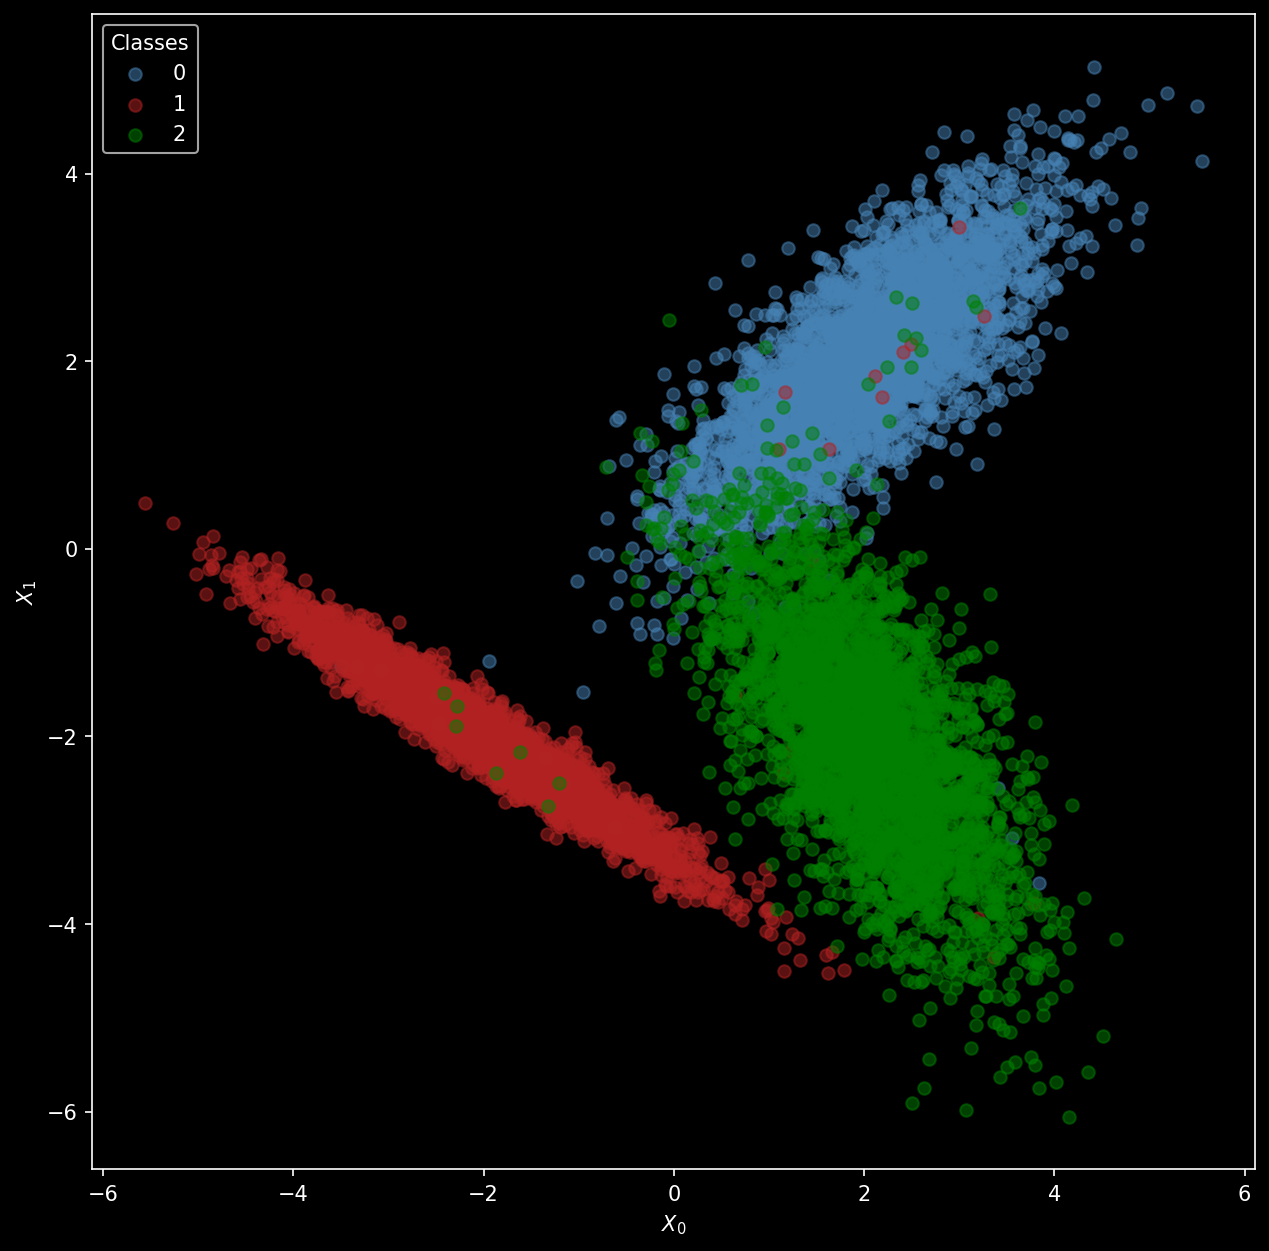

In [404]:
import matplotlib as mpl  # low-level plotting functionality
import matplotlib.pyplot as plt  # general-purpose plotting
from sklearn.datasets import make_classification  # dataset generation
from tqdm.auto import tqdm  # progres bars

# Create arrays for the inputs (X) and target (y)
X, y = make_classification(
    n_samples=10_000, 
    n_classes=3, 
    n_features=2,  # total number of features
    n_informative=2,
    n_redundant=0, 
    n_repeated=0, 
    n_clusters_per_class=1,
    class_sep=2.0  # larger values create clusters farther apart
)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")

fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
# Plot each class label
for n, color in zip(np.unique(y), ['steelblue', 'firebrick', 'green']):
    ax.scatter(X[y==n, 0], X[y==n, 1], alpha=0.5, label=n, c=color)
plt.legend(title='Classes')


plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()

In [416]:
num_classes = np.unique(y).size
print(f"Number of input features: {X.shape[1]}")
print(f"Number of classes: {num_classes}")

# One-hot encode y
# See: https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy/37323404#37323404
y_target = np.eye(num_classes)[y]
print(f"Shape of y_target: {y_target.shape}")

Number of input features: 2
Number of classes: 3
Shape of y_target: (10000, 3)


Initialize the model:

In [417]:
model = nn(
    input_dim = X.shape[1],
    n_layers = 4,
    neurons_per_layer = [4, 10, 6, np.unique(y).size],
    bias = True,
    activation = 'sigmoid',
    lambda_ = 0.1,
    loss_fn = 'cross_entropy',
    alpha = 0.001,
    dtype = np.float32,
    seed = None)

print("Model weights")
for n in range(model.n_layers):
    print(f"Layer {n+1} parameters: {model.params[n+1].shape}")
print(f"Total parameters: {model.n_params:,.0f}")

Model weights
Layer 1 parameters: (3, 4)
Layer 2 parameters: (5, 10)
Layer 3 parameters: (11, 6)
Layer 4 parameters: (7, 3)
Total parameters: 149


In [418]:
y_hat = model.predict(X[:10])
# print(f"Predictions:\n{y_hat}")
# print(f"Targets:\n{y_target[:100]}")
loss = cross_entropy_loss(y_hat, y_target[:10])
print(f"Loss:\n{loss}")
print('=' * 30)

for n, layer in model.outputs.items():
    if n > 0:
        # print(f"Layer {n}, input:  {model.outputs[n-1]['activation'].shape}")
        print(f"Layer {n}, params: {model.params[n].shape}")
        print(f"Layer {n}, z:      {model.outputs[n]['z'].shape}")
    print(f"Layer {n}, output: {layer['activation'].shape}")
    print('-' * 25)

Loss:
1.0555700220943296
Layer 0, output: (10, 3)
-------------------------
Layer 1, params: (3, 4)
Layer 1, z:      (10, 4)
Layer 1, output: (10, 5)
-------------------------
Layer 2, params: (5, 10)
Layer 2, z:      (10, 10)
Layer 2, output: (10, 11)
-------------------------
Layer 3, params: (11, 6)
Layer 3, z:      (10, 6)
Layer 3, output: (10, 7)
-------------------------
Layer 4, params: (7, 3)
Layer 4, z:      (10, 3)
Layer 4, output: (10, 3)
-------------------------


Set up a training loop, including shuffling the data:

In [419]:
n_epochs = 1_000
batch_size = 100
num_samples = X.shape[0]
rng = np.random.default_rng(seed=0)

pbar = tqdm(range(n_epochs))
pbar.set_description(f"Epoch 0/{n_epochs}, loss: {loss:,.4f}")

for epoch in pbar:
    indices = np.arange(num_samples, dtype=int)
    # Shuffle the indices, in place
    rng.shuffle(indices)
    n_batches = np.ceil(num_samples / batch_size).astype(int)
    for batch in range(n_batches):
        start = batch * batch_size
        stop = start + batch_size if (batch + 1 != n_batches) else None
        idxs = indices[start:stop]
        model.zero_grad()
        model.backward(X[idxs], y_target[idxs])
        model.step()
    if (epoch + 1) % (n_epochs // 10) == 0:
        # print(f"Epoch: {epoch+1}/{n_epochs}, loss: {model.loss}")
        pbar.set_description(f"Epoch {epoch+1}/{n_epochs}, loss: {model.loss:,.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [420]:
y_hat = model.predict(X[:10])
print(f"Predictions:\n{y_hat}")
print(f"Targets:\n{y_target[:10]}")

print('=' * 30)

print(f"Class predictions:\n{model.classify(X[:10])}")
print(f"Class targets\n{np.argmax(y_target[:10], axis=1)}")

Predictions:
[[0.31531174 0.38238396 0.30230431]
 [0.29276057 0.33758874 0.36965069]
 [0.29046682 0.32640954 0.38312364]
 [0.38946816 0.29760917 0.31292266]
 [0.31163243 0.30464085 0.38372672]
 [0.30180831 0.31109134 0.38710036]
 [0.3949462  0.31385312 0.29120068]
 [0.28314141 0.33363331 0.38322528]
 [0.40259529 0.29790657 0.29949813]
 [0.30850447 0.30739164 0.3841039 ]]
Targets:
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
Class predictions:
[1 2 2 0 2 2 0 2 0 2]
Class targets
[1 2 2 0 2 2 0 2 0 2]


How large are the parameter values? When using a regularization term (`model.lambda_ > 0`), the weights are reduced each iteration, bringing them closer to 0.

In [421]:
for n, layer in model.params.items():
    print(f"Layer {n}: max weight: {np.max(layer):,.3f}, min weight: {np.min(layer).round(3):,.3f}")

Layer 1: max weight: 1.317, min weight: -1.180
Layer 2: max weight: 2.532, min weight: -1.442
Layer 3: max weight: 1.685, min weight: -1.982
Layer 4: max weight: 2.274, min weight: -1.753


Let's check the overall accuracy of the model by plotting its predictions:

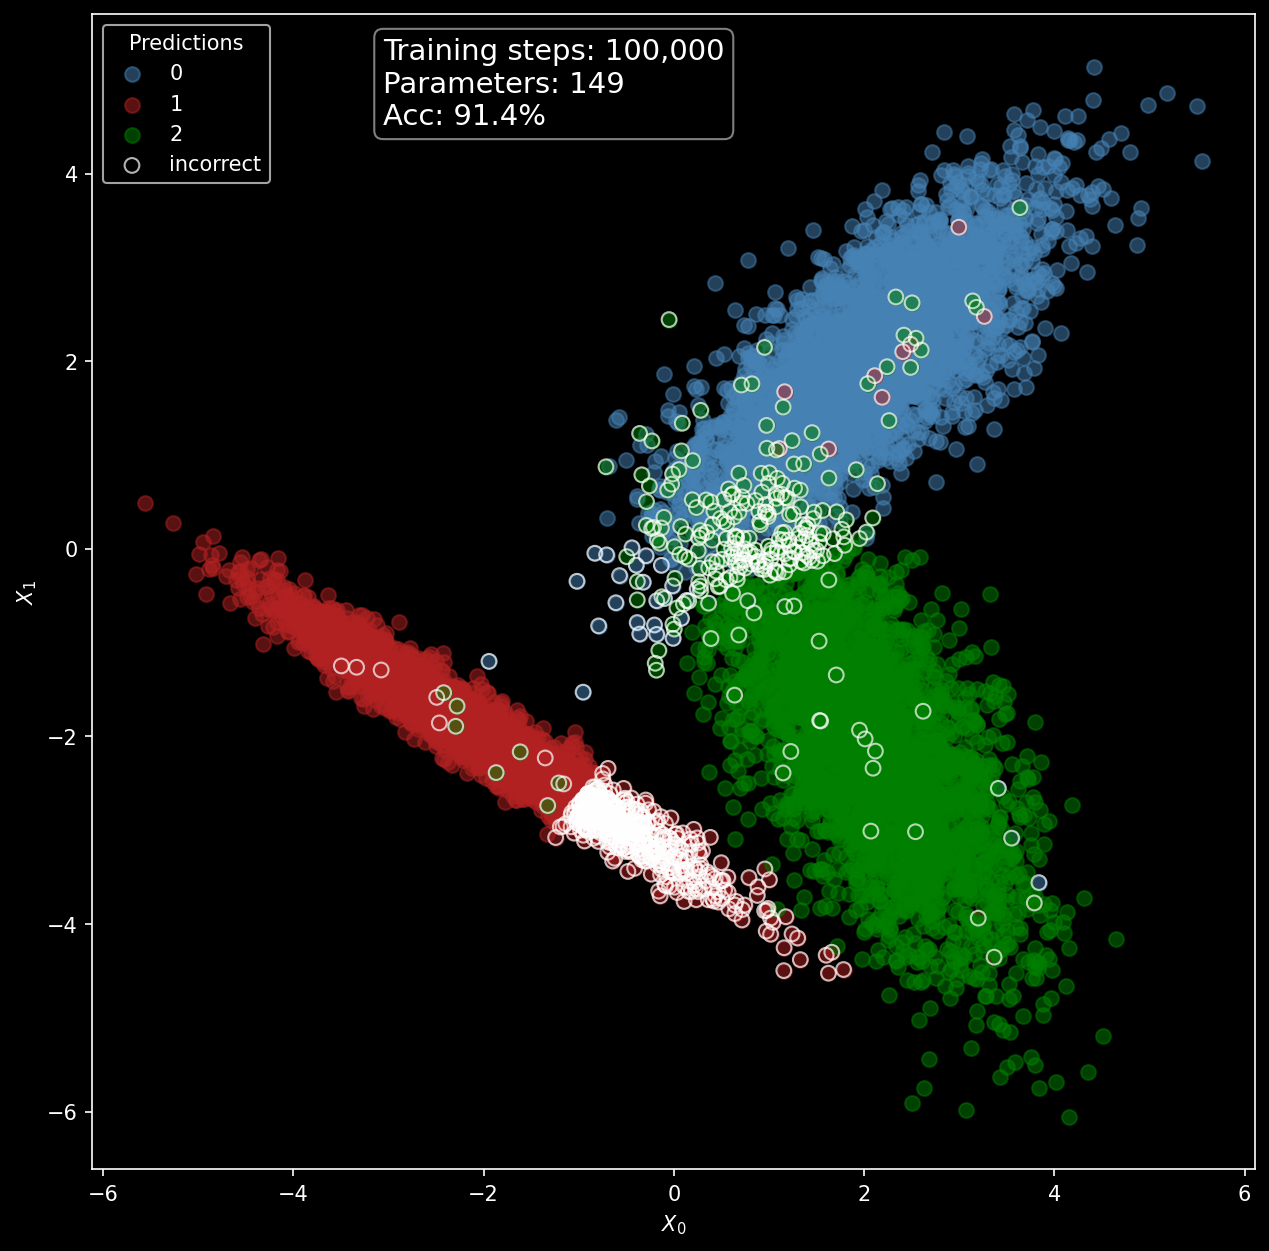

In [422]:
# Predict a class for each sample
y_hat = model.classify(X)

fig, ax = plt.subplots(figsize=(10, 10), dpi=150)

# Plot target values
for n, color in zip(np.unique(y), ['steelblue', 'firebrick', 'green']):
    ax.scatter(X[y==n, 0], X[y==n, 1], alpha=0.5, label=n, s=50, c=color)


# Highlight incorrect predictions
mask_incorrect = (y_hat != y)
ax.scatter(X[mask_incorrect, 0], X[mask_incorrect, 1], label='incorrect',
           edgecolor='white', s=50, facecolors='none', alpha=0.7)

# Calculate accuracy and add a textbox with metrics
# see: https://matplotlib.org/stable/gallery/text_labels_and_annotations/placing_text_boxes.html
num_correct = np.sum(y_hat == y)
acc = num_correct / y_hat.shape[0]  # the number of samples
textstr = '\n'.join((
        f"Training steps: {model.n_steps:,.0f}",
        f"Parameters: {model.n_params}",
        f"Acc: {acc:.1%}"
    ))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='black', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.25, 0.98, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# ax.set_title(f"Number of parameter updates: {model.n_steps}")
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.legend(title='Predictions')
plt.show()

## Regression

# Ideas for next steps
Perform an embedding of products for market basket analysis. For example, see this [Kaggle dataset](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset?select=Groceries_dataset.csv)

# Experiments

Older version of the network, with weights and biases stored separately. Backpropagation not yet implemented for this version of the network.

In [ ]:
class nn():
    '''Create a fully connected neural network with a configurable number of layers and neurons.'''
    def __init__(
            self,
            input_dim: int,
            n_layers: int = 2, 
            neurons_per_layer: Union[int, list[int]] = [3, 1], 
            bias: Union[bool, list[bool]] = True,
            lambda_: float = 0.0,
            loss_fn: str = 'cross_entropy',
            seed: Union[int, None] = None):
        '''Instantiate a neural network as a model object that performs
        computations on input data and returns the outputs
        of those computations. Parameters (weights and biases) are
        intitialized to random values with mean 0 and standard deviation of 1.

        Parameters
        ----------
        input_dim: int
            The dimension of the inputs to the model (i.e, the number
            of features per input sample).
        n_layers: int, default = 2
            The number of layers in the network including all hidden layers
            and the output layer.
        neurons_per_layer: {int, list[int]}, default = [3, 1]
            The number of neurons in each layer of the network. If an `int`,
            then all layers will have the same number of neurons. If a
            `list`, then its `len()` must equal `n_layers`, where each
            element in the list holds the number of neurons in the 
            corresponding layer of the network.
        bias: {bool, list[bool]}, default = True
            Whether to include a bias term for the neurons in the network.
            If `True`, all neurons in the network will have a bias term.
            If a list of `bool` values is provided, each layer of the network
            will (or won't) have a bias term for its neurons based on the
            corresponding element in the list. If a list, the number of
            elements must equal `n_layers`.
        lambda_: float in the range [0.0, inf)
            The weighting factor for the regularizing
            term in the loss calculation. If set to 0.0,
            no regularization will be used. The larger
            this value, the more weights are penalized
            and the smaller the weights will be after
            training through gradient descent.
        loss_fn: {'cross_entropy', 'ce', 'mean_squared_error', 'mse'}
            The loss function used for the network. Valid values are
            'cross_entropy' or 'mean_squared_error' or an abbreviation.
            Use 'mean_squared_error' for regression tasks and set the
            output layer to a single neuron.
            Use 'cross_entropy' for classification tasks and set
            the number of output neurons to the number of possible classes.
            Softmax is automatically applied after the output layer when
            using 'cross_entropy' loss.
        seed: int
            For reproducibility, set a seed that will be used
            when initializing parameter values. 

        Returns
        -------
        self: an instance of `nn` with randomly-initialized weights.

        Methods
        -------
        forward(input): compute a forward pass through the network,
            returning the output from the final layer.
        backward(): compute a backward pass through the network,
            storing the partial derivatives of the parameters
            with respect to the loss.
        zero_grad(): clears (zeros-out) the stored gradients.
        step(learning_rate): update the parameters by taking
            a step (scaled by learning_rate) in the negative
            direction of the gradient.

        Attributes
        ----------
        w: a list of the network's weights by layer
        b: a list of the network's bias values by layer
        n_params: the total number of parameters in the network,
            including weights and biases.
        w_grad: a list of the gradients for each of the weights
            in the network, computed after calling backward().
        b_grad: a list of the gradients for each of the bias values
            in the network, computed after calling backward().
        activations: a list of the intermediate outputs after each layer,
            including the inputs. Used for backpropagation.
        input_dim: the size of the input that will be passed into the
            network. The network will expect all inputs to have this
            same dimension. Since each input sample is a vector, this
            is the number of features in an input row.
        n_layers: The number of layers in the network, including hidden
            layers and the output layer (excluding the input).
        neurons_per_layer: An integer or a list of integers representing
            the number of neurons in each layer.
        bias: A boolean value or a list of boolean values representing
            whether each layer has a bias term added to it.
        '''
        
        # Validate arguments
        if type(input_dim) != int:
            raise TypeError(f"input_dim must be an integer, but the provided value was: {type(input_dim)}")

        if type(n_layers) != int:
            raise TypeError(f"n_layers must be an integer, but the provided value was: {type(n_layers)}")
        
        if type(neurons_per_layer) not in (int, list):
            raise TypeError(f"neurons_per_layer must be an int or a list of int, not: {type(neurons_per_layer)}")
        elif type(neurons_per_layer) == list:
            if len(neurons_per_layer) != n_layers:
                raise ValueError(f"If neurons_per_layer is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != int for i in neurons_per_layer]):
                raise TypeError("neurons_per_layer must be an int or a list of int. Not all elements provided in neurons_per_layer were of the int type.")
        
        if type(bias) not in (bool, list):
            raise TypeError(f"bias must be a bool or a list of bool, not {type(bias)}")
        elif type(bias) == list:
            if len(bias) != n_layers:
                raise ValueError(f"If bias is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != bool for i in bias]):
                raise TypeError("bias must be a bool or a list of bool. Not all elements provided in bias were of the bool type.")
        
        if type(loss_fn) != str:
            raise TypeError(f"loss_fn must be a str value, not {type(loss_fn)}")
        elif loss_fn[0] not in ['c', 'm']:
            raise ValueError(f"loss_fn must be 'cross_entropy', 'mean_squared_error', or an abbreviation, not {loss_fn}")

        if type(seed) not in [int, None]:
            raise TypeError(f"Seed must be an int value, not {type(seed)}")

        # Update object's parameters (equivalent to self.n_layers = n_layers; self.bias = bias; ...)
        self.__dict__.update(locals())

        # If neurons_per_layer and bias are individual values, convert them 
        # to lists to use when creating layers
        if type(neurons_per_layer) == int:
            neurons_per_layer = [neurons_per_layer for _ in range(n_layers)]
        if type(bias) == bool:
            bias = [bias for _ in range(n_layers)]
    
        # Create layers (parameters)
        self.w = []
        self.b = []
        input_sizes = [input_dim]
        input_sizes.extend(neurons_per_layer[:-1])
        for n in range(n_layers):
            w, b = self._linear_layer(
                input_sizes[n], neurons_per_layer[n], bias[n], seed=seed)
            self.w.append(w)
            self.b.append(b)
        
        # The second expression counts bias terms only for layers with a bias
        self.n_params = (np.dot(input_sizes, neurons_per_layer) 
                         + np.dot(bias, neurons_per_layer))


    def _linear_layer(self, input_size: int, n_neurons: int, bias: bool, seed: Union[int, None]):
        '''Create a linear layer. Used when constructing the network
        at time of instantiation.
        
        The input size determines the number of weights (rows) and the
        number of neurons determines the number of columns. The bias
        will be a 1D NumPy array with len() equal to the n_neurons.
        '''
        # set up random number generator
        rng = np.random.default_rng(seed)
        # Generate the weight and bias arrays
        w = rng.normal(size=(input_size, n_neurons))
        if bias:
            b = rng.normal(size=(n_neurons))
        else:
            b = np.zeros(shape=(n_neurons))
        return w, b


    def forward(self, input: np.ndarray, activation: str='relu'):
        '''Pass inputs through the network and return the outputs from
        the final network layer.
        
        Parameters
        ----------
        input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape: m_samples, n_features_per_sample.
        activation: {'relu', 'sigmoid'}, default='relu'
            The activation function to use after passing input through each
            linear layer.
        '''
        # Validate input
        input_size = input.shape[1] if input.ndim > 1 else input.shape[0]
        if input_size != self.input_dim:
            raise ValueError(f"Passed input of size {input_size} does not match"
                             f" expected size of input_dim: {self.input_dim}.")
        
        # Compute at each layer and pass to the next
        y_hat = input
        for n in range(self.n_layers):
            y_hat = linear(x_input=y_hat, weights=self.w[n], bias=self.b[n])
            if activation == 'sigmoid':
                y_hat = sigmoid(y_hat)
            else:
                y_hat = relu(y_hat)        
        return y_hat
        
    
    # Aliases for forward()
    __call__ = forward  # Enables calling the object like a function
    predict = forward




    # weights: list of weight layers, arrays of shape (x_inputs, n_neurons)
    #     The network's weight layers, used for computing
    #     the regularized loss, which penalizes large weights.
    # lambda_: float in the range [0.0, inf)
    #     The weighting factor for the regularizing
    #     term in the loss calculation. If set to 0.0,
    #     no regularization will be used. The larger
    #     this value, the more weights are penalized
    #     and the smaller the weights will be after
    #     training through gradient descent.

    # # Add regularization
    # squared_weights = 0
    # for layer in weights:
    #     squared_weights += np.sum(layer ** 2)
    # loss += (lambda_ * squared_weights) / (2 * num_samples)

In [ ]:
model = nn(input_dim=10, n_layers=4, neurons_per_layer=[3, 4, 6, 2], bias=True)

In [ ]:
for n in range(model.n_layers):
    print(f"Weights: {model.w[n].shape}, bias: {model.b[n].shape}")
print(f"Total parameters: {model.n_params:,.0f}")

In [ ]:
x_input = np.arange(30).reshape(3, 10)
model.forward(x_input, activation='sigmoid')